# 9章 GLMのベイズモデル化と事後分布の推定
## 例題: 種子数のポアソン回帰（個体差なし）

In [1]:
load("data/chap09/d.RData")

In [2]:
ls()

[1] "d"

In [3]:
summary(d)

       x           y        
 Min.   :3   Min.   : 3.00  
 1st Qu.:4   1st Qu.: 5.75  
 Median :5   Median : 7.00  
 Mean   :5   Mean   : 7.30  
 3rd Qu.:6   3rd Qu.: 9.00  
 Max.   :7   Max.   :12.00  

In [4]:
sapply(c("pipeR", "dplyr", "tidyr", "purrr", "ggplot2", "rjags"), require, character.only = TRUE)

Loading required package: pipeR
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: purrr

Attaching package: 'purrr'

The following objects are masked from 'package:dplyr':

    contains, order_by

Loading required package: ggplot2
Loading required package: rjags
Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs


pipeR   dplyr   tidyr   purrr ggplot2   rjags 
   TRUE    TRUE    TRUE    TRUE    TRUE    TRUE

In [5]:
options(repr.plot.width = 4, repr.plot.height = 4)

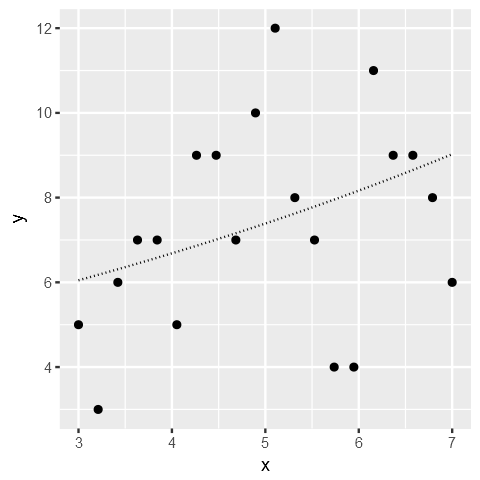

In [6]:
ggplot(aes(x = x, y = y), data = d) + geom_point() + 
    stat_function(geom = "line", fun = function(x){exp(1.5 + 0.1 * x)}, linetype = "dotted") + 
    scale_y_continuous(breaks = seq(4, 12, 2), limits = c(3, 12))

## GLM のベイズモデル化

## 無情報事前分布

## ベイズ統計モデルの事後分布の推定
### ベイズ統計モデルのコーディング

* `JAGS` では行末セミコロンが必要

In [7]:
readLines("chap09-model.jags") %>>% cat(sep = "\n")

model
{
  for (i in 1:N) {
    Y[i] ~ dpois(lambda[i]);
    log(lambda[i]) <- beta1 + beta2 * (X[i] - Mean.X);
  }
  beta1 ~ dnorm(0, 1.0E-4);
  beta2 ~ dnorm(0, 1.0E-4);
}


### 事後分布推定の準備

* データの準備

In [8]:
data.list <- list(
    N = nrow(d), 
    Y = d$y, 
    X = d$x, 
    Mean.X = mean(d$x)
)

* パラメータ初期値

In [40]:
inits.list <- list(
    beta1 = 0, 
    beta2 = 0
)

In [41]:
m <- jags.model(
    file = "chap09-model.jags",
    data = data.list,
    inits = list(inits.list, inits.list, inits.list),
    n.chain = 3
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 20
   Unobserved stochastic nodes: 2
   Total graph size: 128

Initializing model



* burnin

In [11]:
update(m, 100)

* 実行

In [12]:
post.jags <- coda.samples(
    m,
    c("beta1", "beta2"),
    thin = 3, n.iter = 1500
)

In [52]:
saveRDS(post.jags, file = "chap09-post-jags.rds")

In [13]:
str(post.jags)

List of 3
 $ : mcmc [1:500, 1:2] 2.08 2.04 1.98 2.14 2.07 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:2] "beta1" "beta2"
  ..- attr(*, "mcpar")= num [1:3] 1103 2600 3
 $ : mcmc [1:500, 1:2] 1.94 2.19 2.03 2.09 1.94 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:2] "beta1" "beta2"
  ..- attr(*, "mcpar")= num [1:3] 1103 2600 3
 $ : mcmc [1:500, 1:2] 2.04 1.92 1.91 1.9 1.8 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:2] "beta1" "beta2"
  ..- attr(*, "mcpar")= num [1:3] 1103 2600 3
 - attr(*, "class")= chr "mcmc.list"


In [14]:
summary(post.jags)


Iterations = 1103:2600
Thinning interval = 3 
Number of chains = 3 
Sample size per chain = 500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD Naive SE Time-series SE
beta1 1.97650 0.08213 0.002121       0.002174
beta2 0.08522 0.06745 0.001741       0.001626

2. Quantiles for each variable:

          2.5%     25%     50%    75%  97.5%
beta1  1.81288 1.92246 1.97799 2.0305 2.1374
beta2 -0.04221 0.03899 0.08311 0.1322 0.2155


## MCMCサンプルから事後分布を推定

In [15]:
options(repr.plot.height = 6, repr.plot.width = 8)

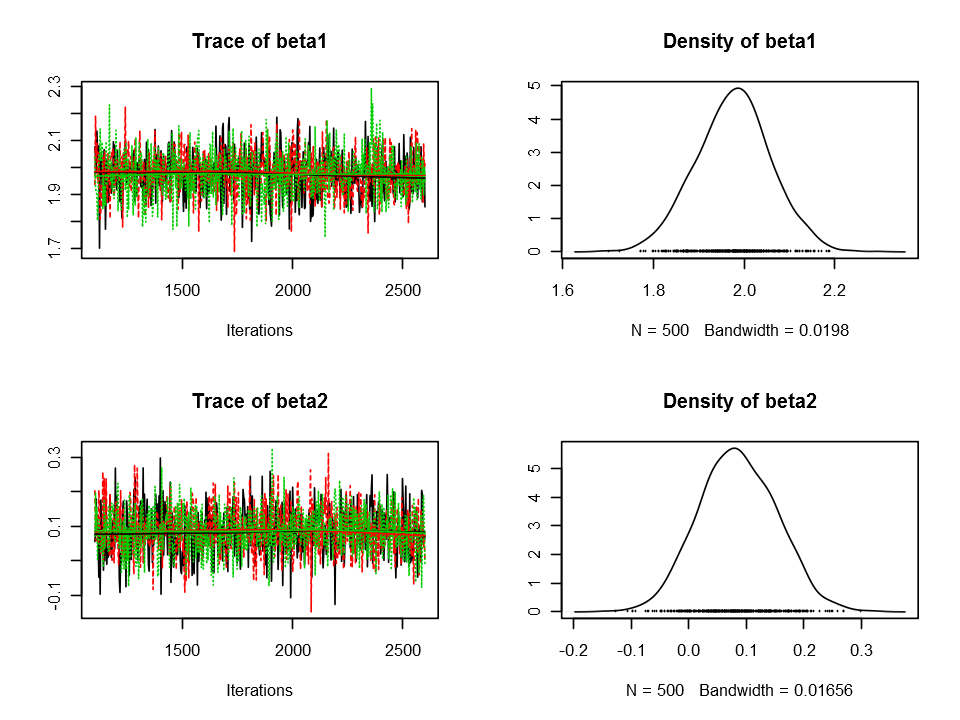

In [16]:
plot(post.jags)

In [17]:
post.jags[[1]] %>>% str()

 mcmc [1:500, 1:2] 2.08 2.04 1.98 2.14 2.07 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "beta1" "beta2"
 - attr(*, "mcpar")= num [1:3] 1103 2600 3


In [18]:
post.jags[[1]] %>>% attributes()

$dim
[1] 500   2

$dimnames
$dimnames[[1]]
NULL

$dimnames[[2]]
[1] "beta1" "beta2"


$mcpar
[1] 1103 2600    3

$class
[1] "mcmc"

In [19]:
post.jags[[1]][, c("beta1", "beta2")] %>>% as_data_frame() %>>% str()

Classes 'tbl_df', 'tbl' and 'data.frame':	500 obs. of  2 variables:
 $ beta1: num  2.08 2.04 1.98 2.14 2.07 ...
 $ beta2: num  0.0553 0.0776 0.1788 0.0796 0.1194 ...


In [20]:
post.jags %>>% purrr::map_df(function(x){
    x[, c("beta1", "beta2")] %>>% as_data_frame()
}) %>>% str()

Classes 'tbl_df', 'tbl' and 'data.frame':	1500 obs. of  2 variables:
 $ beta1: num  2.08 2.04 1.98 2.14 2.07 ...
 $ beta2: num  0.0553 0.0776 0.1788 0.0796 0.1194 ...


In [21]:
post.jags %>>% purrr::map_df(function(x){
    x[, c("beta1", "beta2")] %>>% as_data_frame()
}) -> post.jags.df

In [22]:
post.jags.df$beta1[[1]]

[1] 2.077023

In [24]:
options(repr.plot.width = 4, repr.plot.height = 4)

In [27]:
post.jags.df %>>% head(10)

beta1,beta2
2.077023,0.05527736
2.041796,0.07763919
1.979890,0.17878409
2.136080,0.07956061
2.070155,0.11944600
2.035921,0.05765377
2.080131,-0.04813629
1.699948,0.10008357
2.036581,-0.09724805
1.960755,0.17518093


In [33]:
summary(post.jags)


Iterations = 1103:2600
Thinning interval = 3 
Number of chains = 3 
Sample size per chain = 500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD Naive SE Time-series SE
beta1 1.97650 0.08213 0.002121       0.002174
beta2 0.08522 0.06745 0.001741       0.001626

2. Quantiles for each variable:

          2.5%     25%     50%    75%  97.5%
beta1  1.81288 1.92246 1.97799 2.0305 2.1374
beta2 -0.04221 0.03899 0.08311 0.1322 0.2155


In [47]:
summary(post.jags) %>>% str()

List of 6
 $ statistics: num [1:2, 1:4] 1.9765 0.08522 0.08213 0.06745 0.00212 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2] "beta1" "beta2"
  .. ..$ : chr [1:4] "Mean" "SD" "Naive SE" "Time-series SE"
 $ quantiles : num [1:2, 1:5] 1.8129 -0.0422 1.9225 0.039 1.978 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2] "beta1" "beta2"
  .. ..$ : chr [1:5] "2.5%" "25%" "50%" "75%" ...
 $ start     : num 1103
 $ end       : num 2600
 $ thin      : num 3
 $ nchain    : int 3
 - attr(*, "class")= chr "summary.mcmc"


In [49]:
summary(post.jags)$quantiles["beta1", "50%"]

[1] 1.977992

In [50]:
summary(post.jags)$quantiles["beta2", "50%"]

[1] 0.08311006

In [31]:
options(expressions = 50000)

In [42]:
post.jags.df %>>% 
    {map2((.)$beta1, (.)$beta2, function(beta1, beta2){
        stat_function(mapping = aes(x), 
                      data = data_frame(x = c(3, 7)), 
                      geom = "line", 
                      fun = function(x, beta1, beta2){
                          exp(beta1 + beta2 * (x - mean(d$x)))}, 
                      args = list(beta1 = beta1, beta2 = beta2), 
                      colour = gray(0.8, 0.1))
    })} -> lambdas

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 11 rows containing missing values (geom_path)."Warning message:
"Removed 6 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_path)."Warning message:
"Removed 7 rows containing missing values (geom_path)."Warning message:
"Removed 4 rows containing missing values (geom_path)."Warning message:
"Removed 12 rows containing missing values (geom_path)."Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 3 rows containing missing values (geom_path)."Warning message:
"Removed 3 rows containing missing values (geom_path)."Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_path)."Warning message:
"Removed 4 rows containing missing values (ge

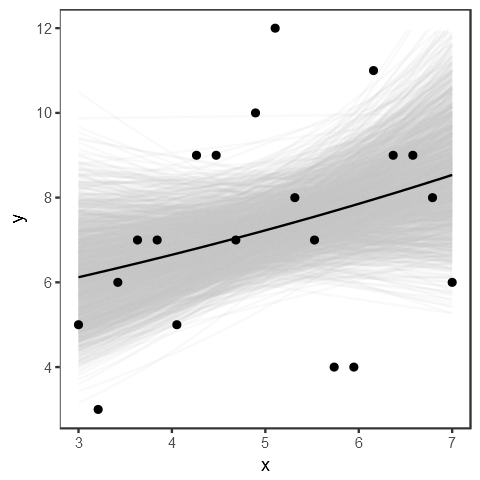

In [61]:
ggplot() + 
    lambdas +
    theme_bw() + theme(panel.grid = element_blank()) + 
    geom_point(data = d, mapping = aes(x = x, y = y)) + 
    stat_function(data = data_frame(x = c(3, 7)), 
                         mapping = aes(x), 
                         geom = "line", 
                         fun = function(x){
                             exp(summary(post.jags)$quantiles["beta1", "50%"] + 
                                 summary(post.jags)$quantiles["beta2", "50%"] * (x - mean(d$x)))}, 
                         colour = "black") + 
    scale_y_continuous(breaks = seq(4, 12, 2), limits = c(3, 12))

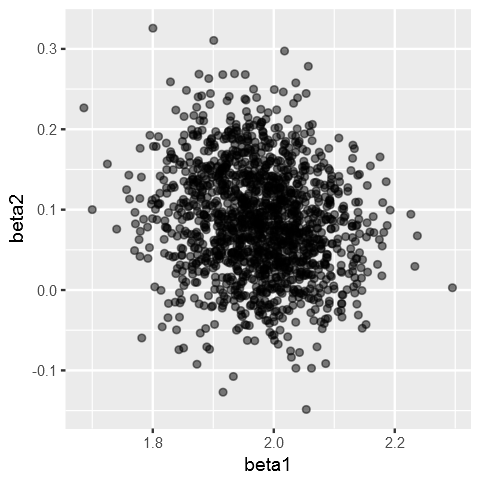

In [28]:
post.jags.df %>>% 
    ggplot(aes(x = beta1, y = beta2)) + 
        geom_point(colour = gray(0.5)) + 
        theme_bw() + theme(panel.grid = element_blank())

In [35]:
coda::gelman.diag(post.jags)

Potential scale reduction factors:

      Point est. Upper C.I.
beta1      1.000          1
beta2      0.999          1

Multivariate psrf

1

In [179]:
options(repr.plot.width = 8)

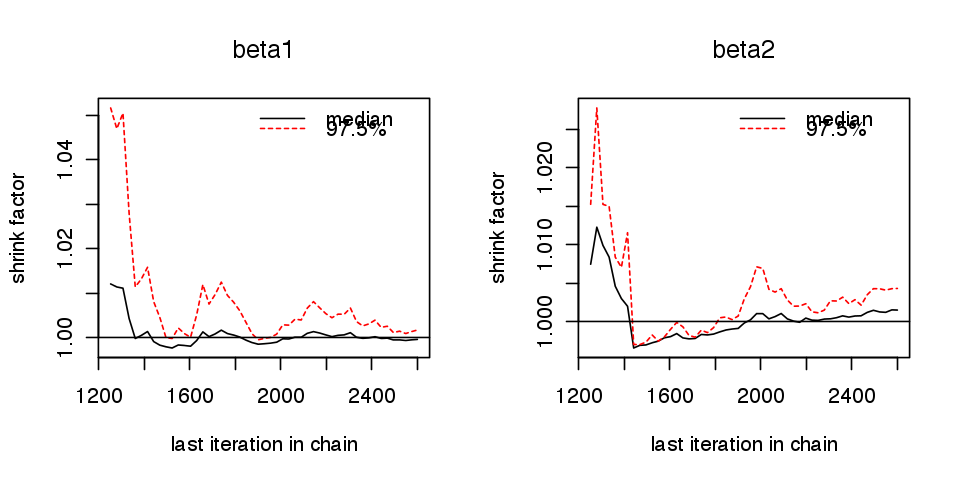

In [180]:
coda::gelman.plot(post.jags)